# SABR CALIBRATION PROJECT

## IMPORT LIBRARIES AND OPTIONS DATA

I downloaded the option data as an xlsx file directly from bloomberg.
I chose to analyze the DAX index options, since it does not pay dividends and the options are european style.
The data were downloaded on the 30/01/2025 so i keep that as reference date.

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# upload excel file downloaded from bloomberg
IV_data = pd.read_excel('DAX_data.xlsx', engine='openpyxl')


## DATA CLEANING AND PREPARATION

I clean the data and chose only the most liquid options strikes, so i can properly calibrate the model on a coherent volatility surface.

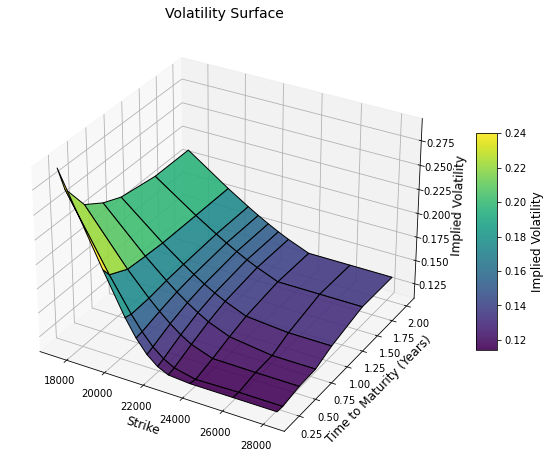

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Date of data download
reference_date = pd.to_datetime('2025-01-30')

# DAX index closing price 2025-01-29
reference_price = 21637.53

file_path = "DAX_data.xlsx" 
data = pd.read_excel(file_path, engine="openpyxl", header=[0, 1]) 

data.columns = data.columns.droplevel(0)

data.columns = ['Expiry', 'Exp Date', 'ImpFwd'] + [float(strike) for strike in data.columns[3:]]

# Filter for specified maturities
selected_maturities = ['2M','3M', '6M', '9M', '1Y', '18M', '2Y']

data = data[data['Expiry'].isin(selected_maturities)]


data['Exp Date'] = pd.to_datetime(data['Exp Date'], format='%d %b %Y', errors='coerce')

# Calculate Time to Maturity
data['TimeToMaturity'] = (data['Exp Date'] - reference_date).dt.days / 365.0

# Determine ATM strike (closest to the ImpFwd value)
atm_strike = data['ImpFwd'].iloc[0]  
strikes = [float(col) for col in data.columns[3:-1]]

# Find the 10 strikes above and below ATM
strikes_around_atm = sorted(strikes, key=lambda x: abs(x - atm_strike))[:10]

# Filter for selected strikes
filtered_data = data[['Expiry', 'Exp Date', 'TimeToMaturity'] + [strike for strike in strikes_around_atm]]


vol_surface_df = filtered_data.melt(
    id_vars=['TimeToMaturity'], 
    value_vars=filtered_data.columns[3:],  
    var_name='Strike', 
    value_name='IV'
)

# Add the implied forward price to vol_surface_df
vol_surface_df = vol_surface_df.merge(
    data[['TimeToMaturity', 'ImpFwd']],
    on='TimeToMaturity',
    how='left'
)


# Convert 'Strike' and 'IV' to numeric
vol_surface_df['Strike'] = pd.to_numeric(vol_surface_df['Strike'], errors='coerce')
vol_surface_df['IV'] = pd.to_numeric(vol_surface_df['IV'], errors='coerce')/100

vol_surface_df = vol_surface_df.dropna()


vol_surface_pivot = vol_surface_df.pivot_table(
    values='IV',
    index='Strike',
    columns='TimeToMaturity'
)


def plot_vol_surface(vol_surface_pivot):

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    X, Y = np.meshgrid(vol_surface_pivot.columns, vol_surface_pivot.index)
    Z = vol_surface_pivot.values

    surf = ax.plot_surface(Y, X, Z, cmap='viridis', edgecolor='k', alpha=0.9)

    cbar = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
    cbar.set_label('Implied Volatility', fontsize=12)

    ax.set_title("Volatility Surface", fontsize=14)
    ax.set_xlabel('Strike', fontsize=12)
    ax.set_ylabel('Time to Maturity (Years)', fontsize=12)
    ax.set_zlabel('Implied Volatility', fontsize=12)

    plt.show()


plot_vol_surface(vol_surface_pivot)

In [57]:
vol_surface_df

,TimeToMaturity,Strike,IV,ImpFwd
0,0.161644,21718.0,0.1308,21841.31
1,0.246575,21718.0,0.1332,21915.19
2,0.495890,21718.0,0.1411,22115.85
3,0.747945,21718.0,0.1470,22248.28
4,1.000000,21718.0,0.1509,22398.59
...,...,...,...,...
65,0.495890,28233.0,0.1179,22115.85
66,0.747945,28233.0,0.1188,22248.28
67,1.000000,28233.0,0.1263,22398.59
68,1.495890,28233.0,0.1356,22773.72


## MODEL DEFINITION AND MINIMIZATION

I define the sabr model equations, the cost function and perform the calibration for each maturity.

In [58]:
from scipy.optimize import minimize


def sabr_volatility(alpha, beta, rho, nu, F, K, T):
    epsilon = 1e-8  # Small value to avoid log(0) issues

    # Compute z safely
    if F == K:
        z = 0  # Avoid division by zero for ATM case
        x_z = 1  # Prevent log(0) issue
    else:
        z = (nu / alpha) * ((F * K) ** ((1 - beta) / 2)) * np.log(F / K)
        x_z_term = np.sqrt(1 - 2 * rho * z + z**2) + z - rho

        
        arg = x_z_term / (1 - rho)
        arg = np.maximum(arg, epsilon)  # Ensure positivity
        x_z = np.log(arg)

    # Compute volatility using the corrected terms
    factor1 = alpha / (((F * K) ** ((1 - beta) / 2)) * (1 + ((1 - beta) ** 2 / 24) * (np.log(F / K)) ** 2 + ((1 - beta) ** 4 / 1920) * (np.log(F / K)) ** 4))
    factor2 = z / x_z
    factor3 = 1 + T * ((1 - beta) ** 2 * alpha ** 2 / (24 * ((F * K) ** (1 - beta))) + rho * beta * alpha * nu / (4 * ((F * K) ** ((1 - beta) / 2))) + (2 - 3 * rho ** 2) * nu ** 2 / 24)
    
    return factor1 * factor2 * factor3


# MSE function to minimize
def mse_objective(params, beta, vol_surface_df):
    alpha, rho, nu = params
    mse = 0
    count = 0  
    for _, row in vol_surface_df.iterrows():
        F = row['ImpFwd']
        K = row['Strike']
        T = row['TimeToMaturity']
        market_vol = row['IV']
        
        if T > 0 and K > 0:
            model_vol = sabr_volatility(alpha, beta, rho, nu, F, K, T)
            mse += (market_vol - model_vol) ** 2
            count += 1
    return mse / count if count > 0 else np.nan 


unique_maturities = vol_surface_df['TimeToMaturity'].unique()

calibrated_params_list = []

# Fixed beta and parameter bounds (same for all maturities)
beta = 0.95
bounds = [(1e-8, 50), (-0.99, 0.99), (1e-8, 10)]
initial_guess = [0.1, -0.1, 0.1]

# Calibrate for each maturity 
for maturity in unique_maturities:
    
    maturity_df = vol_surface_df[vol_surface_df['TimeToMaturity'] == maturity]
    
    if len(maturity_df) == 0:
        continue
    
    result = minimize(
        lambda params: mse_objective(params, beta, maturity_df),
        x0=initial_guess,
        bounds=bounds,
        method='L-BFGS-B',  
        options={'maxiter': 1000, 'ftol': 1e-8} 
    )
    
    
    if result.success:
        alpha, rho, nu = result.x
        cost = result.fun
        calibrated_params_list.append({
            'TimeToMaturity': maturity,
            'Alpha': alpha,
            'Rho': rho,
            'Nu': nu,
            'Beta': beta,  
            'Final Cost': cost
        })
    else:
        print(f"Calibration failed for maturity {maturity}")

calibrated_params_df = pd.DataFrame(calibrated_params_list)

print("Calibrated Parameters per Maturity:")
print(calibrated_params_df)

Calibrated Parameters per Maturity:
   TimeToMaturity     Alpha       Rho        Nu  Beta  Final Cost
0        0.161644  0.225955 -0.804327  1.668081  0.95    0.000161
1        0.246575  0.222888 -0.764816  1.433202  0.95    0.000080
2        0.495890  0.224533 -0.678948  1.117048  0.95    0.000020
3        0.747945  0.231350 -0.652512  0.934568  0.95    0.000006
4        1.000000  0.233864 -0.579713  0.839483  0.95    0.000002
5        1.495890  0.232271 -0.465126  0.771367  0.95    0.000002
6        2.000000  0.224023 -0.423155  0.769207  0.95    0.000002


## MONTE CARLO SIMULATION FOR ASIAN OPTION PRICING

In [62]:
def simulate_trajectories(option_params, model_params, n_sims, n_steps):
    """
    Parameters:
        option_params (dict): Contains 'spot' (initial forward), 'T' (time to maturity).
        model_params (dict): Contains 'sigma0' (initial volatility), 'beta', 'rho', and 'nu'.
        n_sims (int): Number of Monte Carlo simulations.
        n_steps (int): Number of time steps.
        
    Returns:
        prices (np.ndarray): Simulated forward price paths.
        volatilities (np.ndarray): Simulated volatility paths.
    """
    prices = np.zeros((n_sims, n_steps + 1))
    volatilities = np.zeros((n_sims, n_steps + 1))
    
    prices[:, 0] = option_params['spot']
    volatilities[:, 0] = model_params['alpha']
    
    dt = option_params['T'] / n_steps
    
    for t in range(1, n_steps + 1):
        # Generate two sets of independent normals
        dW1 = np.random.normal(0, np.sqrt(dt), n_sims)
        dW2 = np.random.normal(0, np.sqrt(dt), n_sims)
        # Create correlated increment for the volatility process
        dZ2 = model_params['rho'] * dW1 + np.sqrt(1 - model_params['rho']**2) * dW2
        
        # Update forward price using the SABR dynamics
        prices[:, t] = prices[:, t - 1] + volatilities[:, t - 1] * (prices[:, t - 1] ** model_params['beta']) * dW1
        
        # Update volatility using SABR dynamics (Euler discretization)
        volatilities[:, t] = volatilities[:, t - 1] + model_params['nu'] * volatilities[:, t - 1] * dZ2
        
        # Ensure volatility stays positive
        volatilities[:, t] = np.maximum(volatilities[:, t], 1e-8)
        
    return prices, volatilities

def compute_asian_price(prices, option_params):
    """
    The payoff is computed as:
        payoff = max(average_price - strike, 0)
    and then discounted.
    
    Parameters:
        prices (np.ndarray): Simulated forward price paths.
        option_params (dict): Contains 'strike', 'T' (maturity) and 'r' (risk-free rate).
        
    Returns:
        option_price (float): Estimated Asian option price.
        option_devstd (float): Standard error of the option price estimate.
    """

    avg_prices = np.mean(prices[:, 1:], axis=1)
    payoffs = np.maximum(avg_prices - option_params['strike'], 0)
    option_price = np.exp(-option_params['r'] * option_params['T']) * np.mean(payoffs)
    option_devstd = np.std(payoffs) / np.sqrt(prices.shape[0]) * np.exp(-option_params['r'] * option_params['T'])
    return option_price, option_devstd



# Chose maturity for asian option pricing
maturity_asian = 1.0

# ESTR interst rates on 30/01/2025
ESTR_rate = 0.02923

# Find the maturity closest to chosen asian option maturity and extract SABR calibrated parameters
calibrated_params_df['maturity_diff'] = np.abs(calibrated_params_df['TimeToMaturity'] - maturity_asian)
chosen_row = calibrated_params_df.loc[calibrated_params_df['maturity_diff'].idxmin()]

model_params = {
    'alpha': chosen_row['Alpha'],  
    'beta': chosen_row['Beta'],
    'rho': chosen_row['Rho'],
    'nu': chosen_row['Nu']
}

option_params = {
    'spot': reference_price,       
    'strike': reference_price,     
    'T': maturity_asian,            
    'r': ESTR_rate            
}

# Simulation settings
n_sims = 1000
n_steps = 252  

prices, volatilities = simulate_trajectories(option_params, model_params, n_sims, n_steps)

asian_price, asian_std = compute_asian_price(prices, option_params)
print(f"Asian Option Price: {asian_price:.4f} , Std Error: {asian_std:.4f}")

Asian Option Price: 696.2192 , Std Error: 28.6580


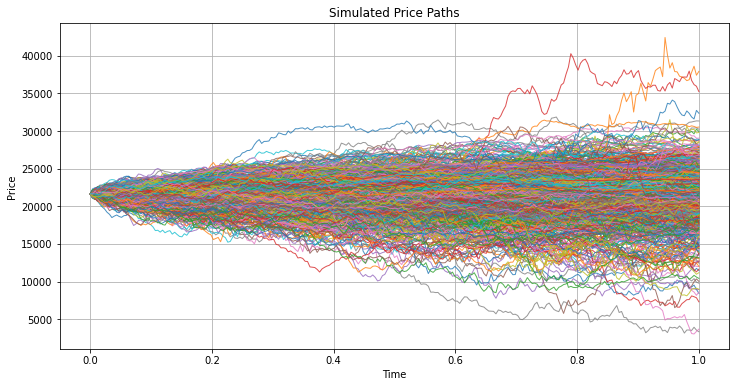

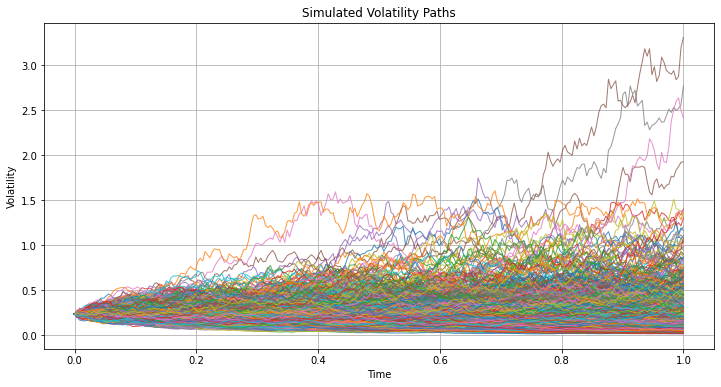

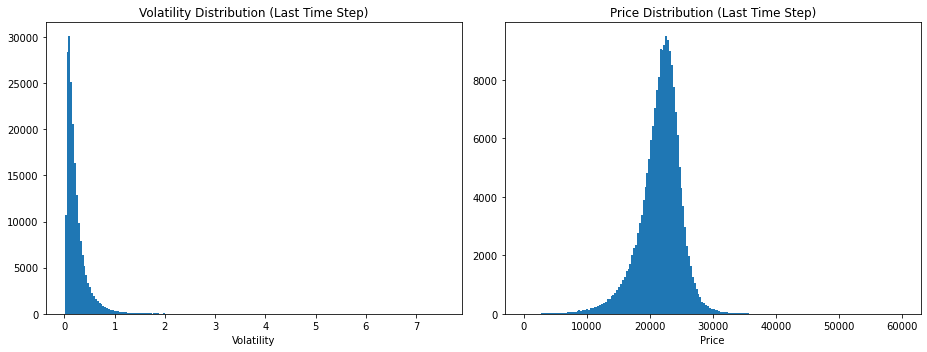

In [54]:
time_grid = np.linspace(0, option_params['T'], n_steps + 1)


# choose the number of paths to display
num_paths_to_plot = 1000 

plt.figure(figsize=(12, 6))
for i in range(num_paths_to_plot):
    plt.plot(time_grid, prices[i, :], lw=1, alpha=0.8)
plt.title("Simulated Price Paths")
plt.xlabel("Time")
plt.ylabel("Price")
plt.grid(True)
plt.show()


plt.figure(figsize=(12, 6))
for i in range(num_paths_to_plot):
    plt.plot(time_grid, volatilities[i, :], lw=1, alpha=0.8)
plt.title("Simulated Volatility Paths")
plt.xlabel("Time")
plt.ylabel("Volatility")
plt.grid(True)
plt.show()


fig, axs = plt.subplots(1, 2, figsize=(13, 5))
axs[0].set_title("Volatility Distribution (Last Time Step)")
axs[0].hist(volatilities[:, -1], bins=200)
axs[0].set_xlabel("Volatility")

axs[1].set_title("Price Distribution (Last Time Step)")
axs[1].hist(prices[:, -1], bins=200)
axs[1].set_xlabel("Price")

plt.tight_layout()
plt.show()
